In [1]:
import numpy as np  
import matplotlib.pyplot as plt
from lambeq.backend.quantum import Ry, Diagram, Bra, Rx, Rz
from util import data_loader, gen_bloch_states, get_observable, plot_scatter, plot_dist, plot_heatmap, gen_states
from contextuality.model import chsh_scenario, Model
import seaborn as sns
from funcs import calc_eoe, calc_neg, state2dense, gen_basis, calc_violation, normalise, log_neg, get_table
import pandas as pd
from tqdm import tqdm
import random
from math import floor

In [2]:
CF_bound = 2**0.5 - 1
bell_state = np.array([1,0,0,1], dtype=np.complex128) * 1/(2**0.5)

x_basis = gen_basis(np.pi/2, 0)
y_basis = gen_basis(np.pi/2, np.pi/2)
z_basis = gen_basis()

onb1 = gen_basis(np.pi/2, np.pi/8)[0]
onb2 = gen_basis(np.pi/2, 5*np.pi/8)[0]

contexts_cc = {'ab': np.kron(onb1, onb1), 
               'aB': np.kron(onb1, onb2),  
               'Ab': np.kron(onb2, onb1),  
               'AB': np.kron(onb2, onb2)}
_observables = {'A': (get_observable('ONB1', np.pi/2, np.pi/8), get_observable('ONB2', np.pi/2, 5*np.pi/8)), 'B': (get_observable('ONB1', np.pi/2, np.pi/8), get_observable('ONB2', np.pi/2, 5*np.pi/8))}
observables = {'A': (get_observable('a1', 0, 0), get_observable('a2', np.pi/4, 0)), 'B': (get_observable('b1', np.pi/8, 0), get_observable('b2', 5*np.pi/8, 0))}
contexts_max = {'ab': np.kron(observables['A'][0].array, observables['B'][0].array),
                'aB': np.kron(observables['A'][0].array, observables['B'][1].array), 
                'Ab': np.kron(observables['A'][1].array, observables['B'][0].array), 
                'AB': np.kron(observables['A'][1].array, observables['B'][1].array)}

# bell_state = np.array([1,0,0,1]) * 1/(2**0.5)
# prs1 = abs(contexts_cc['ab'] @ bell_state)**2
# prs2 = abs(contexts_cc['aB'] @ bell_state)**2
# prs3 = abs(contexts_cc['Ab'] @ bell_state)**2
# prs4 = abs(contexts_cc['AB'] @ bell_state)**2
# Model(chsh_scenario(), convert_dist([prs1, prs2, prs3, prs4])).contextual_fraction()
subj_obj_pairs = [('heart', 'blood'), ('sailors', 'boats'), ('students', 'books'), ('knife', 'fence'),
                  ('storm', 'flight'), ('bee', 'flower'), ('birds', 'seeds'), ('police', 'criminals'), 
                  ('people', 'government'), ('sniper', 'terrorist')]
conv_arr = lambda arr: abs(np.array([ele for ele in arr]))

In [3]:
model_path = {'d_ref': 'runs/disjoint_ref_130E/best_model.lt', 
              'd_nref': 'runs/disjoint_noref_140E/best_model.lt',
              's_ref': 'runs/spider_ref_200E/best_model.lt', 
              's_nref': 'runs/spider_noref_50E/best_model.lt'}

diagram_path = {'rref': 'dataset/diagrams/diags_right_ref.pkl',
                'wref': 'dataset/diagrams/diags_wrong_ref.pkl',
                'nref': 'dataset/diagrams/diags_no_ref.pkl'}

data_path = {'d_rref': 'dataset/new_data_pkl/open-wire_right_ref.pkl',
             'd_wref': 'dataset/new_data_pkl/open-wire_wrong_ref.pkl',
             'd_nref': 'dataset/new_data_pkl/open-write_no_ref.pkl',
             's_rref': 'dataset/new_data_pkl/spider_right_ref.pkl',
             's_wref': 'dataset/new_data_pkl/spider_wrong_ref.pkl',
             's_nref': 'dataset/new_data_pkl/spider_no_ref.pkl',}

In [4]:
right_ref = data_loader(chsh_scenario())
right_ref.load_circuits(diagram_path['rref'])

wrong_ref = data_loader(chsh_scenario())
wrong_ref.load_circuits(diagram_path['wref'])

no_ref = data_loader(chsh_scenario())
no_ref.load_circuits(diagram_path['nref'])

In [5]:
ow_rref = data_loader(chsh_scenario())
ow_rref.load_data(data_path['d_rref'])
ow_wref = data_loader(chsh_scenario())
ow_wref.load_data(data_path['d_wref'])
ow_nref = data_loader(chsh_scenario())
ow_nref.load_data(data_path['d_nref'])

s_rref = data_loader(chsh_scenario())
s_rref.load_data(data_path['s_rref'])
s_wref = data_loader(chsh_scenario())
s_wref.load_data(data_path['s_wref'])
s_nref = data_loader(chsh_scenario())
s_nref.load_data(data_path['s_nref'])

In [10]:
from sklearn import svm
data_r, data_w = get_sim([ow_rref.data.sample(frac=1), ow_wref.data.sample(frac=1)])
total = len(data_r)
data_1 = data_r[:round(total*0.8)]
data_2 = data_w[:round(total*0.8)]
data = np.concatenate([list(data_1['LogNeg'].to_numpy()), 
                       list(data_2['LogNeg'].to_numpy())])
data = [[ele] for ele in data]
data = list(zip(data, [1]*round(total*0.8) + [0]*round(total*0.8)))
random.shuffle(data)
data, labels = zip(*data)
predictor = svm.SVC()
predictor.fit(list(data), list(labels))

SVC()

In [11]:
test1 = data_r['LogNeg'][round(total*0.8):]
test2 = data_w['LogNeg'][round(total*0.8):]
test1 = [[ele] for ele in test1]
test2 = [[ele] for ele in test2]
res1 = predictor.predict(test1)
res2 = predictor.predict(test2)
print("Distinguish right and wrong referents")
print(f"Right referent accuracy: {(sum(res1)/len(res1))*100}")
print(f"Wrong referent accuracy: {(sum(res2)/len(res2))*100}")
print(f"Total accuracy: {(sum(res1) + sum(res2))/(len(res1)+len(res2))*100 }")

Distinguish right and wrong referents
Right referent accuracy: 44.71403812824957
Wrong referent accuracy: 35.875216637781634
Total accuracy: 40.294627383015595


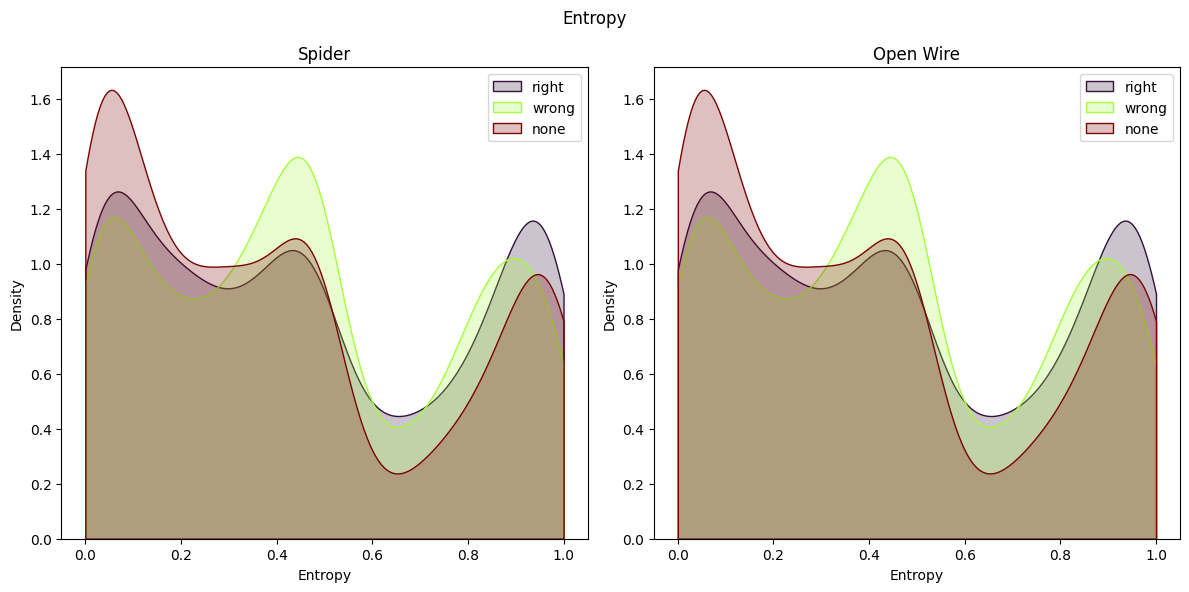

In [547]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(1,2,1)
plot_dist(ax, [s_rref.data['Entropy'], s_wref.data['Entropy'], s_nref.data['Entropy']], ['right', 'wrong', 'none'], "Spider")

ax = fig.add_subplot(1,2,2)
plot_dist(ax, [ow_rref.data['Entropy'], ow_wref.data['Entropy'], ow_nref.data['Entropy']], ['right', 'wrong', 'none'], "Open Wire")

fig.suptitle("Entropy")
fig.tight_layout()
#fig.savefig("figures/new_figs/cnxt")
#fig.supxlabel("CbD Measure")
#fig.supylabel("Contextual Fraction")

In [205]:
spearmanr(a['CF'], a['CbD'])

SignificanceResult(statistic=0.12412263212500321, pvalue=5.945133145752443e-12)

In [7]:
def get_sim(df_arr):
    common_sentences = [[] for _ in df_arr]
    min_i = 0
    for i in range(len(df_arr)):
        if len(df_arr[i]) < len(df_arr[min_i]):
            min_i = i
    min_df = df_arr.pop(min_i)
    for i, row in min_df.iterrows():
        res_arr = []
        for df in df_arr:
            res = df.loc[df['Sentence'] == row['Sentence']]
            if len(res) == 0:
                break
            res_arr.append(res.index[0])
        if len(res_arr) == len(df_arr):
            res_arr.insert(min_i, i)
            for j in range(len(res_arr)):
                common_sentences[j].append(res_arr[j])
    df_arr.insert(min_i, min_df)
    return [df.iloc[ints] for df, ints in zip(df_arr, common_sentences)]